In [39]:
%matplotlib inline

import ipyth_word2_vec
import os
import time
import argparse
import ipyth_utils
import csv
import numpy as np
import pandas as pd
import codecs
import time
from sklearn.preprocessing import scale, LabelBinarizer
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import cross_validation
from sklearn.ensemble import AdaBoostClassifier
import matplotlib.pyplot as plt

from multiprocessing import Pool

## word2vec model and logging:
from gensim.models import word2vec
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

In [40]:
## For model evaluation:
def evaluate_score (y_model, y_real):
    model_score = sum(y_model==y_real)/len(y_real)
    return model_score

### step 1 reading library with documents or pretrained vectors

In [41]:
## Get wiki docs:
libarary_dir = '../data/wiki_data'

def read_wiki_docs_text (libarary_dir):
    docs = []

    for fname in os.listdir(libarary_dir):
        path = os.path.join(libarary_dir, fname)
        words = ipyth_utils.tokenize(open(path).read(),ngram = 1)  #word2vec data doesn't need tokenization
        docs.append(words)
        
    return docs

library_data = read_wiki_docs_text (libarary_dir)



In [43]:
## Text Example:
print(library_data[0][0:400])
print ("\n")
print ("total number of docs: ", len (library_data))

['papua', 'earthquake', 'occurred', 'moment', 'magnitude', 'january', 'local', 'time', 'killing', 'least', 'four', 'injuring', 'dozens', 'people', 'epicenter', 'kilometres', 'mi', 'west', 'northwest', 'manokwari', 'km', 'mi', 'east', 'northeast', 'sorong', 'indonesia', 'west', 'papua', 'province', 'bird', 'head', 'peninsula', 'official', 'world', 'vision', 'said', 'ten', 'buildings', 'totally', 'destroyed', 'including', 'several', 'hotels', 'house', 'government', 'official', 'officials', 'said', 'three', 'people', 'staying', 'mutiara', 'hotel', 'city', 'manokwari', 'pulled', 'alive', 'rubble', 'taken', 'hospital', 'two', 'hotels', 'collapsed', 'quake', 'twenty', 'three', 'aftershocks', 'magnitude', 'one', 'magnitude', 'occurring', 'local', 'time', 'january', 'utc', 'another', 'magnitude', 'earthquake', 'also', 'felt', 'nearby', 'papua', 'new', 'guinea', 'darwin', 'australia', 'see', 'also', 'west', 'papua', 'earthquake', 'papua', 'earthquake', 'references', 'external', 'links', 'earthq

Learning Classifier

In [46]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 1   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
#downsampling = 1e-3   # Downsample setting for frequent words


train_model = True
#f_model_path = "D:\Wikipedia & others\\freebase-vectors-skipgram1000.bin\\"
#f_model_name = "knowledge-vectors-skipgram1000.bin"

f_model_name = "ck12_wiki_data"

print (f_model_path)

# Initialize and train the model (this will take some time)
if train_model:
    
    print ("Training model...")
    start_time = time.time()
    wiki_word2vecmodel = word2vec.Word2Vec(library_data, workers=num_workers, \
                size=num_features, min_count = min_word_count, \
                window = context)

    # If you don't plan to train the model any further, calling 
    # init_sims will make the model much more memory-efficient.
    wiki_word2vecmodel.init_sims(replace=True)

    # It can be helpful to create a meaningful model name and 
    # save the model for later use. You can load it later using Word2Vec.load()
    wiki_word2vecmodel.save(f_model_name)
    print ("Model trained and saved. Time passed in minutes: ",round((time.time() - start_time)/60,2))

if not train_model:
    start_time = time.time()
    wiki_word2vecmodel = word2vec.Word2Vec.load_word2vec_format(f_model_path + f_model_name, binary=False)
    print ("Model loaded. Time passed in minutes: ",round((time.time() - start_time)/60,2))

D:\Wikipedia & others\freebase-vectors-skipgram1000.bin\
Training model...
Model trained and saved. Time passed in minutes:  0.54


### step 2 reading initial data

In [50]:
## Loadin train data
fname_str = 'joined_set.tsv'

data = pd.read_csv('../data/' + fname_str, sep = '\t')

In [51]:
## Evaluating model

res, prob_score = ipyth_word2_vec.predict_cosine_answers (data, wiki_word2vecmodel,num_features,ngram = 1)

y = data.iloc[0:2500,6]
y_predict = res[0:2500]
evaluate_score(y_predict, y)

0.3412

Now we need to fine tune all parameters


In [66]:
## Varying num_features
num_features = 140    # Word vector dimensionality                      
min_word_count = 1   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
sg = 0                # 0 - cbow, 1 - n-gram

par_range  = np.arange (20,200,20)
scores = []


start_time = time.time()
for par_iter in par_range:
    print ("Training model...")
    num_features = par_iter
    
    wiki_word2vecmodel = word2vec.Word2Vec(library_data, workers = num_workers, \
                size = par_iter, min_count = min_word_count, \
                window = context, sg = 1)
    
    ## Evaluating model
    res, prob_score = ipyth_word2_vec.predict_cosine_answers (data, wiki_word2vecmodel, num_features, ngram=1)
    wiki_word2vecmodel.init_sims(replace=True)
    y = data.iloc[0:2500,6]
    y_predict = res[0:2500]
    print (par_iter," -- ",evaluate_score(y_predict, y))
    scores.append(evaluate_score(y_predict, y))


print ("Parameter estimation time: ",(time.time()-start_time)/60)

Training model...
20  --  0.3116
Training model...
40  --  0.3276
Training model...
60  --  0.3372
Training model...
80  --  0.3472
Training model...
100  --  0.3404
Training model...
120  --  0.3364
Training model...
140  --  0.3496
Training model...
160  --  0.3492
Training model...
180  --  0.3416
Parameter estimation time:  6.1844441016515095


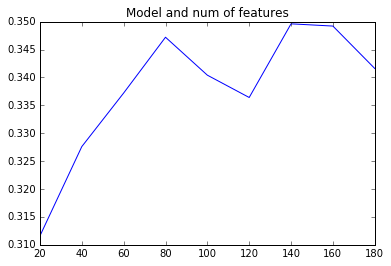

In [67]:
plt.plot(par_range,scores)
plt.title ("Model and num of features")
plt.show()

And now we introdyce best trained model

In [56]:
## Best Model

num_features = 140    # Word vector dimensionality                      
min_word_count = 1   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
sg = 1                # 0 - cbow, 1 - n-gram

wiki_word2vecmodel = word2vec.Word2Vec(library_data, workers=4, \
                size=num_features, min_count = min_word_count, \
                window = context)

    
## Evaluating model
res, prob_score = ipyth_word2_vec.predict_cosine_answers (data, wiki_word2vecmodel,num_features, ngram=1)
print ("finished predicting probabilities")
y = data.iloc[0:2500,6]
y_pred = res[0:2500]
print (evaluate_score (y_pred,y))

finished predicting probabilities
0.3472
